In [1]:
import itertools as it
import copy
import json
import os.path as op
import pickle
import matplotlib.pylab as plt
from matplotlib import colors
from extra.tools import many_is_in
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
import statsmodels.api as sm
from scipy.linalg import eig
from scipy.stats import spearmanr

In [2]:
sensors = [
    'MLC21', 'MLC22', 'MLC23', 'MLC24', 
    'MLC31', 'MLC41', 'MLC51', 'MLC52', 
    'MLC53', 'MLC61', 'MLC62'
]

columns = [
    'trial',
    'peak_freq',
    'peak_amp_iter',
    'peak_amp_base',
    'peak_time',
    'peak_adjustment',
    'fwhm_freq',
    'fwhm_time',
    'polarity',
    'block',
    'pp_ix',
    'subject',
    'sensor',
    'trial_type'
]

In [ ]:
path = "/home/mszul/datasets/explicit_implicit_beta/derivatives/processed"
subs = files.get_folders_files(path)[0]
subs = [op.join(i, "3SD_bursts") for i in subs]
subs = [i for i in subs if op.exists(i)]
subs.sort()

json_files = {}
for sub in subs:
    sub_id = sub.split(sep)[-2]
    subs_bursts = files.get_files(sub, "", ".json")[2]
    subs_bursts = [i for i in subs_bursts if many_is_in(sensors, i)]
    subs_bursts.sort()
    json_files[sub_id] = subs_bursts

all_files = [y for i in json_files.keys() for y in json_files[i]]

In [5]:
_3SD_features = "/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/3SD_features.csv"
_3SD_waveforms = "/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/3SD_waveforms.npy"

if all([op.exists(_3SD_features), op.exists(_3SD_waveforms)]):
    waveforms = np.load(_3SD_waveforms)
    columns_dict = pd.read_csv(_3SD_features)
else:
    waveforms = []
    columns_dict = {i: [] for i in columns}
    for f in tqdm(all_files):
        with open(f) as pipeline_file:
            data_single = json.load(pipeline_file)
        info = np.array(f.split(sep)[-1].split("-"))
        sensor = info[1]
        subject = "-".join(info[2:4])
        trial_type = info[4]
        shape = np.array(data_single["pp_ix"]).shape[0]
        for c in columns:
            if c == "sensor":
                columns_dict["sensor"].extend(np.tile(sensor, shape).tolist())
                pass
            elif c == "trial_type":
                columns_dict["trial_type"].extend(np.tile(trial_type, shape).tolist())
            elif c == "subject":
                columns_dict["subject"].extend(np.tile(subject, shape).tolist())
            else:
                columns_dict[c].extend(data_single[c])
        waveforms.append(np.array(data_single["waveform"]))

    columns_dict = pd.DataFrame.from_dict(columns_dict)
    columns_dict.to_csv(_3SD_features, index=False)
    waveforms = np.vstack(waveforms)
    np.save(_3SD_waveforms, waveforms)

In [37]:
max_wvf = np.max(waveforms, axis=1)
max_wvf_prc = [np.percentile(max_wvf, 1), np.percentile(max_wvf, 99)]
max_wvf_map = ((max_wvf >= max_wvf_prc[0]) & (max_wvf <= max_wvf_prc[1]))

In [51]:
waveforms = waveforms[max_wvf_map,:]
columns_dict = columns_dict.loc[max_wvf_map]

In [38]:
def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

SNR = signaltonoise(waveforms, axis=0, ddof=1)

In [17]:
times = np.linspace(-130, 130, num=156)
mean_waveform = np.mean(waveforms, axis=0)

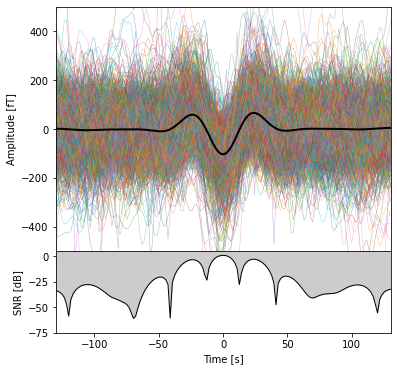

In [48]:
fig = plt.figure(figsize=(6, 6), constrained_layout=False)
grid = fig.add_gridspec(2,1, wspace=0, hspace=0, height_ratios=(4.5, 1.5))
xx0 = grid[0, 0].subgridspec(1,1)
ax0 = xx0.subplots()
ax0.set_xticks([])
ax0.plot(times, waveforms[::5000,:].T/1e-15, lw=0.5, alpha=0.5)
ax0.plot(times, mean_waveform/1e-15, lw=2, c="black")
ax0.set_xlim(times[0], times[-1])
ax0.set_ylim(-500, 500)
ax0.set_ylabel("Amplitude [fT]")

xx1 = grid[1, 0].subgridspec(1,1)
ax1 = xx1.subplots()
ax1.fill_between(times, np.zeros(times.shape)+10, 10*np.log10(SNR**2), lw=0, color="black", alpha=0.2)
ax1.plot(times, 10*np.log10(SNR**2), lw=1, color="black")
ax1.set_xlim(times[0], times[-1])
ax1.set_ylim(-75, 5)
ax1.set_ylabel("SNR [dB]")
ax1.set_xlabel("Time [s]")
ax1.set_yticks([0, -25, -50, -75])
plt.savefig("/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/images/3SD_waveform.svg")

In [50]:
columns_dict.loc[max_wvf_map]

(6938798, 14)

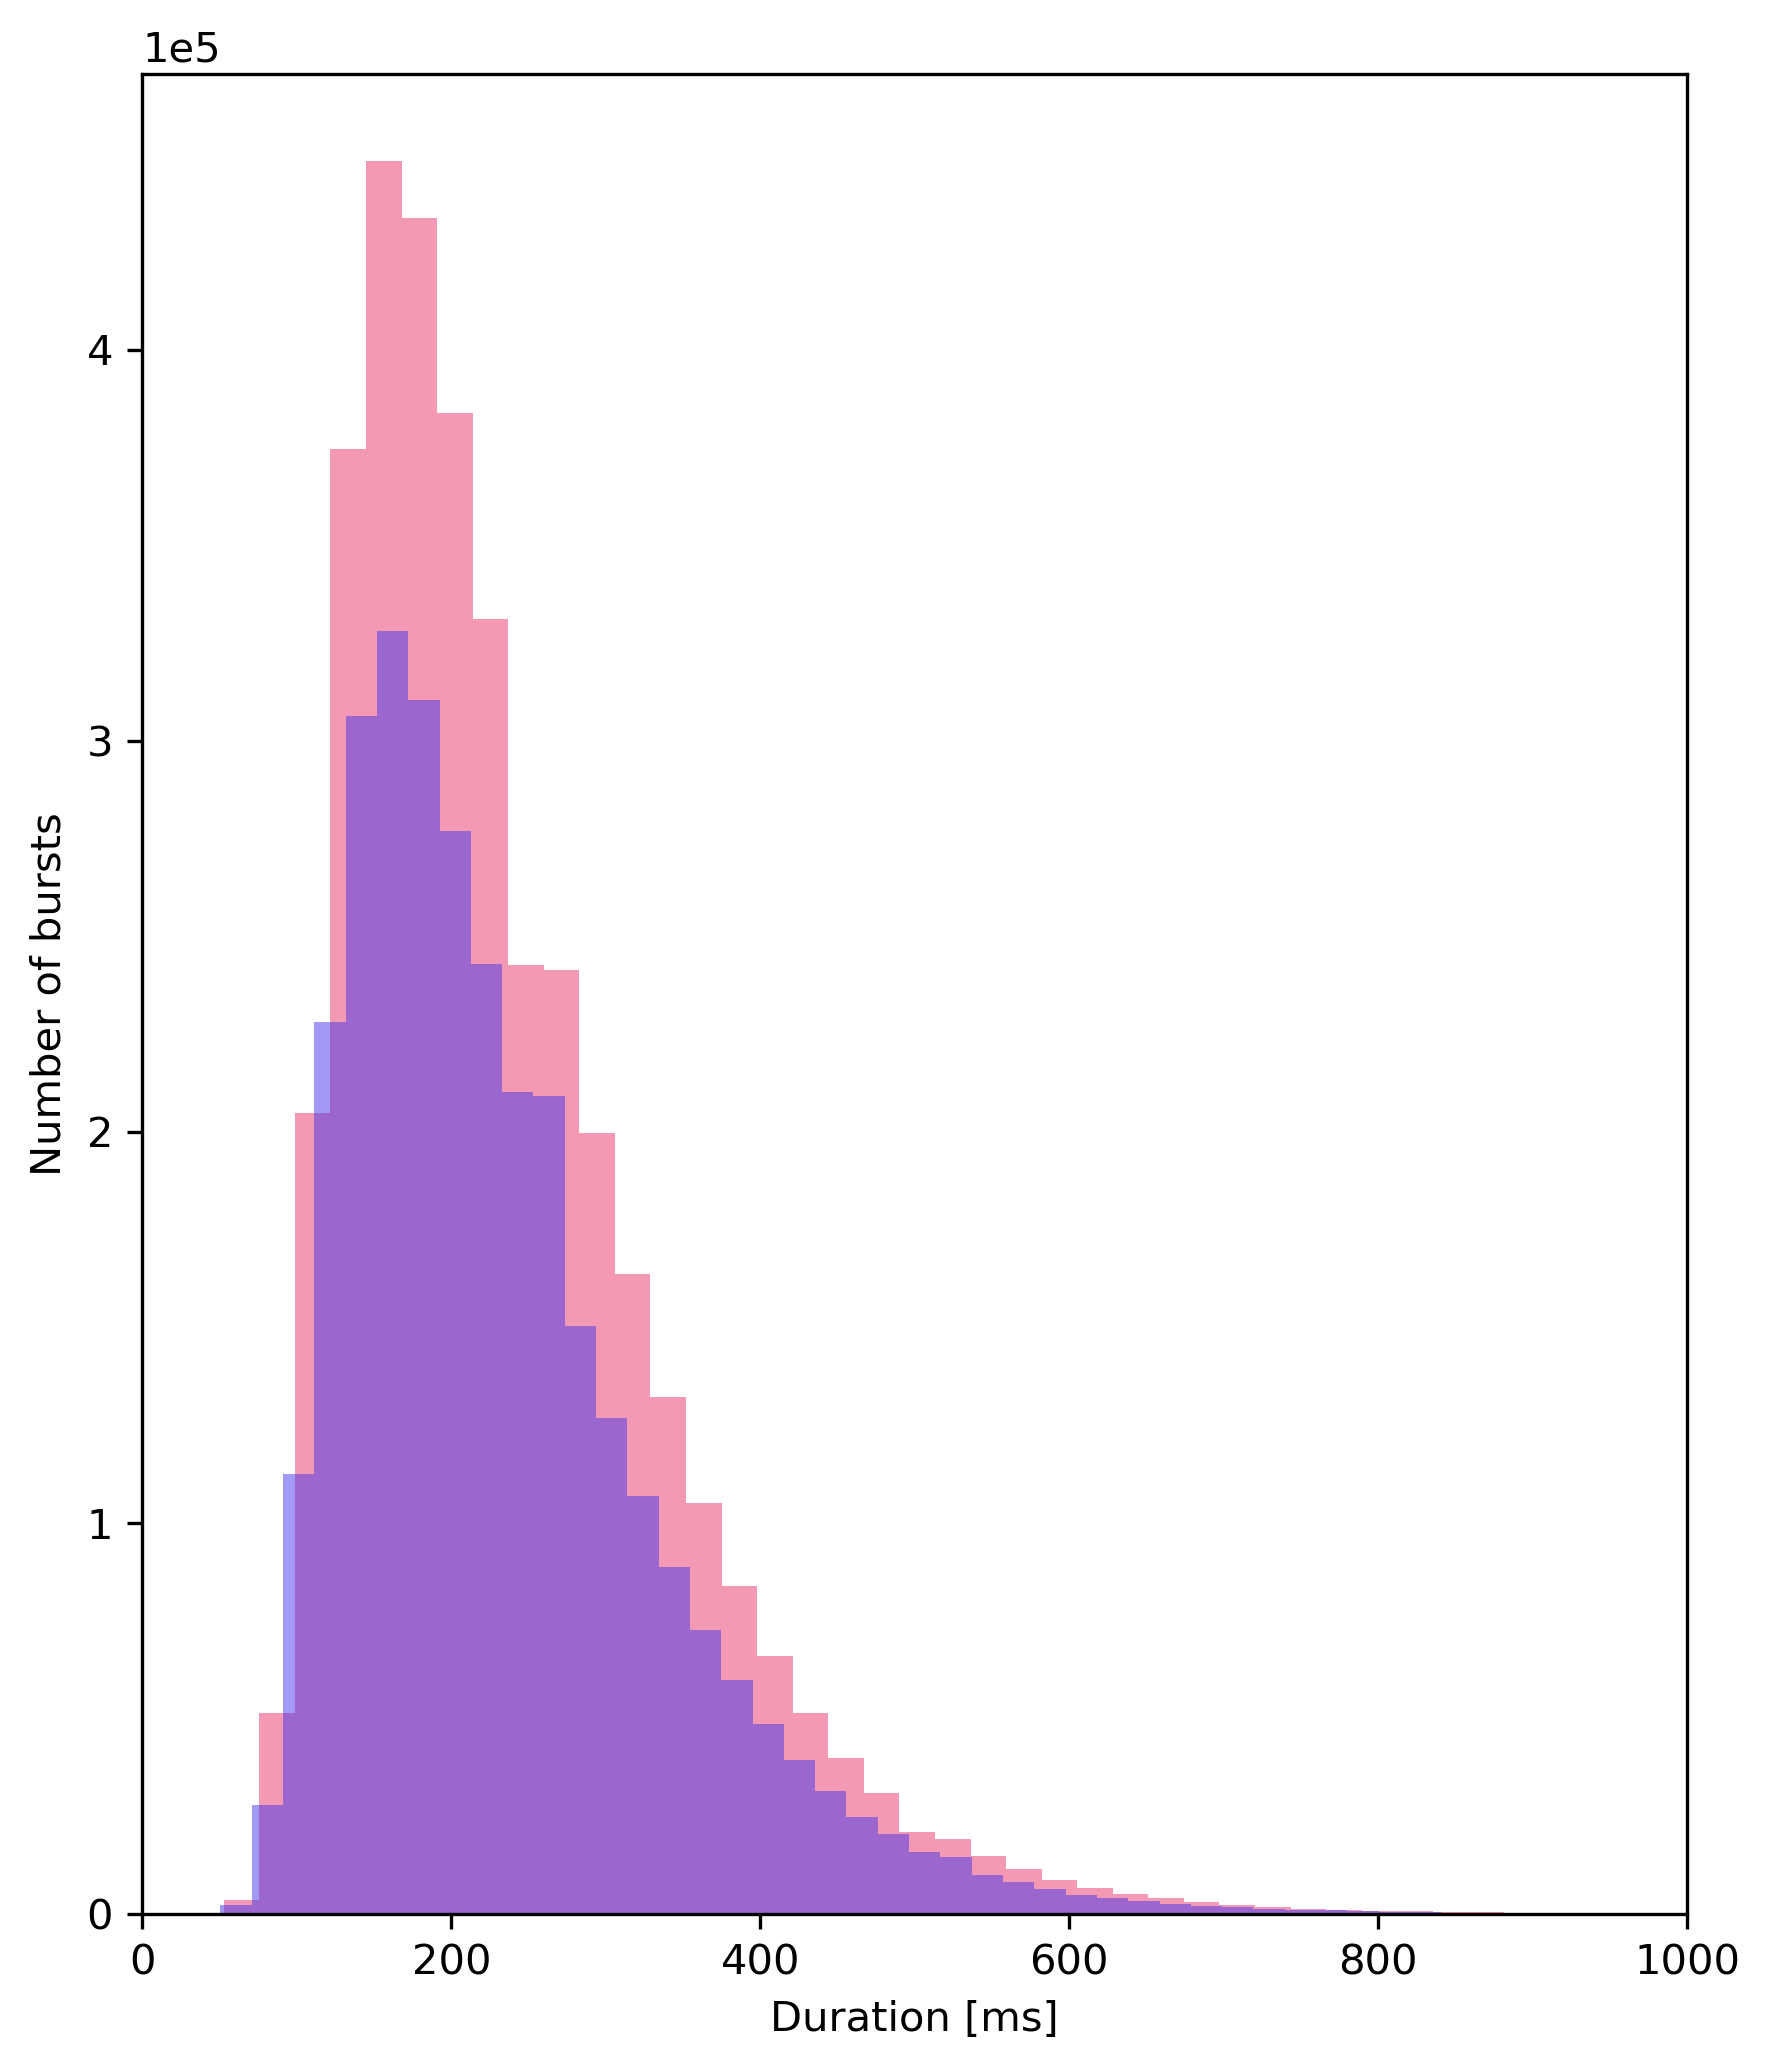

In [6]:
cw_m = "#4634eb"
cw_v = "#eb346b"

f, ax = plt.subplots(1, 1, figsize=(6, 7), dpi=300)
ax.hist(columns_dict.loc[columns_dict.trial_type == "visual"].fwhm_time.values*1e3, bins=75, alpha=0.5, color=cw_v);
ax.hist(columns_dict.loc[columns_dict.trial_type == "motor"].fwhm_time.values*1e3, bins=75, alpha=0.5, color=cw_m);
ax.set_xlim(0, 1000)
ax.set_ylabel("Number of bursts")
ax.set_xlabel("Duration [ms]")
ax.ticklabel_format(axis="y", style="sci", scilimits=(10, 3))
plt.tight_layout()
plt.savefig("/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/images/3SD_burst_duration_hist.svg")

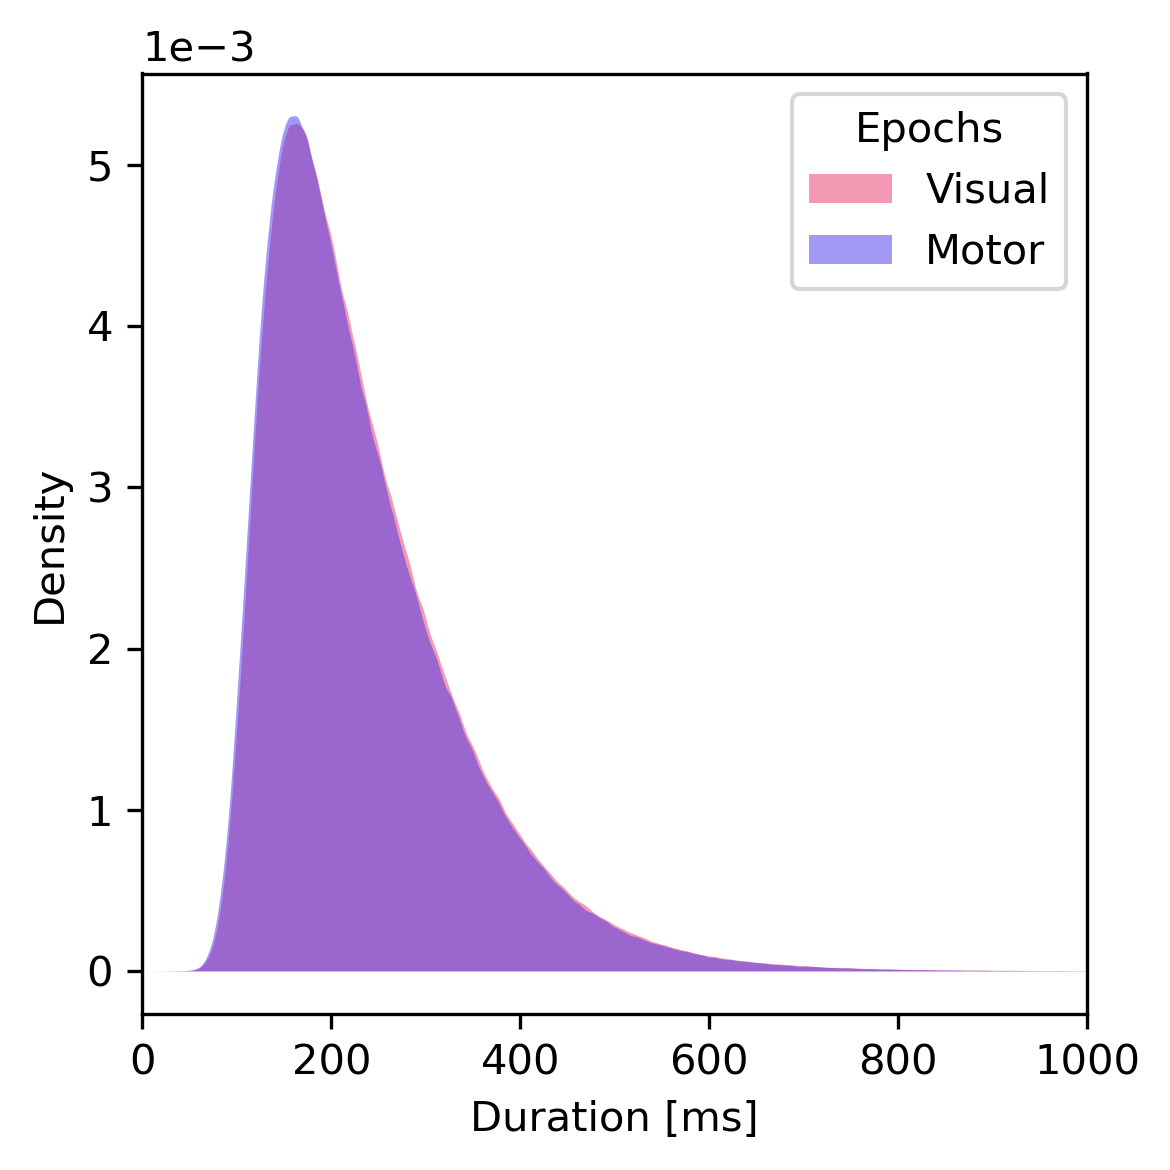

In [16]:
cw_m = "#4634eb"
cw_v = "#eb346b"

f, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=300)

kde_vis = sm.nonparametric.KDEUnivariate(columns_dict.loc[columns_dict.trial_type == "visual"].fwhm_time.values*1e3)
kde_vis.fit(bw=2.9)
kde_mot = sm.nonparametric.KDEUnivariate(columns_dict.loc[columns_dict.trial_type == "motor"].fwhm_time.values*1e3)
kde_mot.fit(bw=2.9)

ax.fill_between(kde_vis.support, 0, kde_vis.density, lw=0, color=cw_v, label="Visual", alpha=0.5, rasterized=True)
ax.fill_between(kde_mot.support, 0, kde_mot.density, lw=0, color=cw_m, label="Motor", alpha=0.5, rasterized=True)
ax.set_xlim(0, 1000)
ax.legend(title="Epochs")
ax.ticklabel_format(axis="y", style="sci", scilimits=(10, 3))
ax.set_ylabel("Density")
ax.set_xlabel("Duration [ms]")
plt.tight_layout()
plt.savefig("/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/images/3SD_burst_duration_kde.svg")

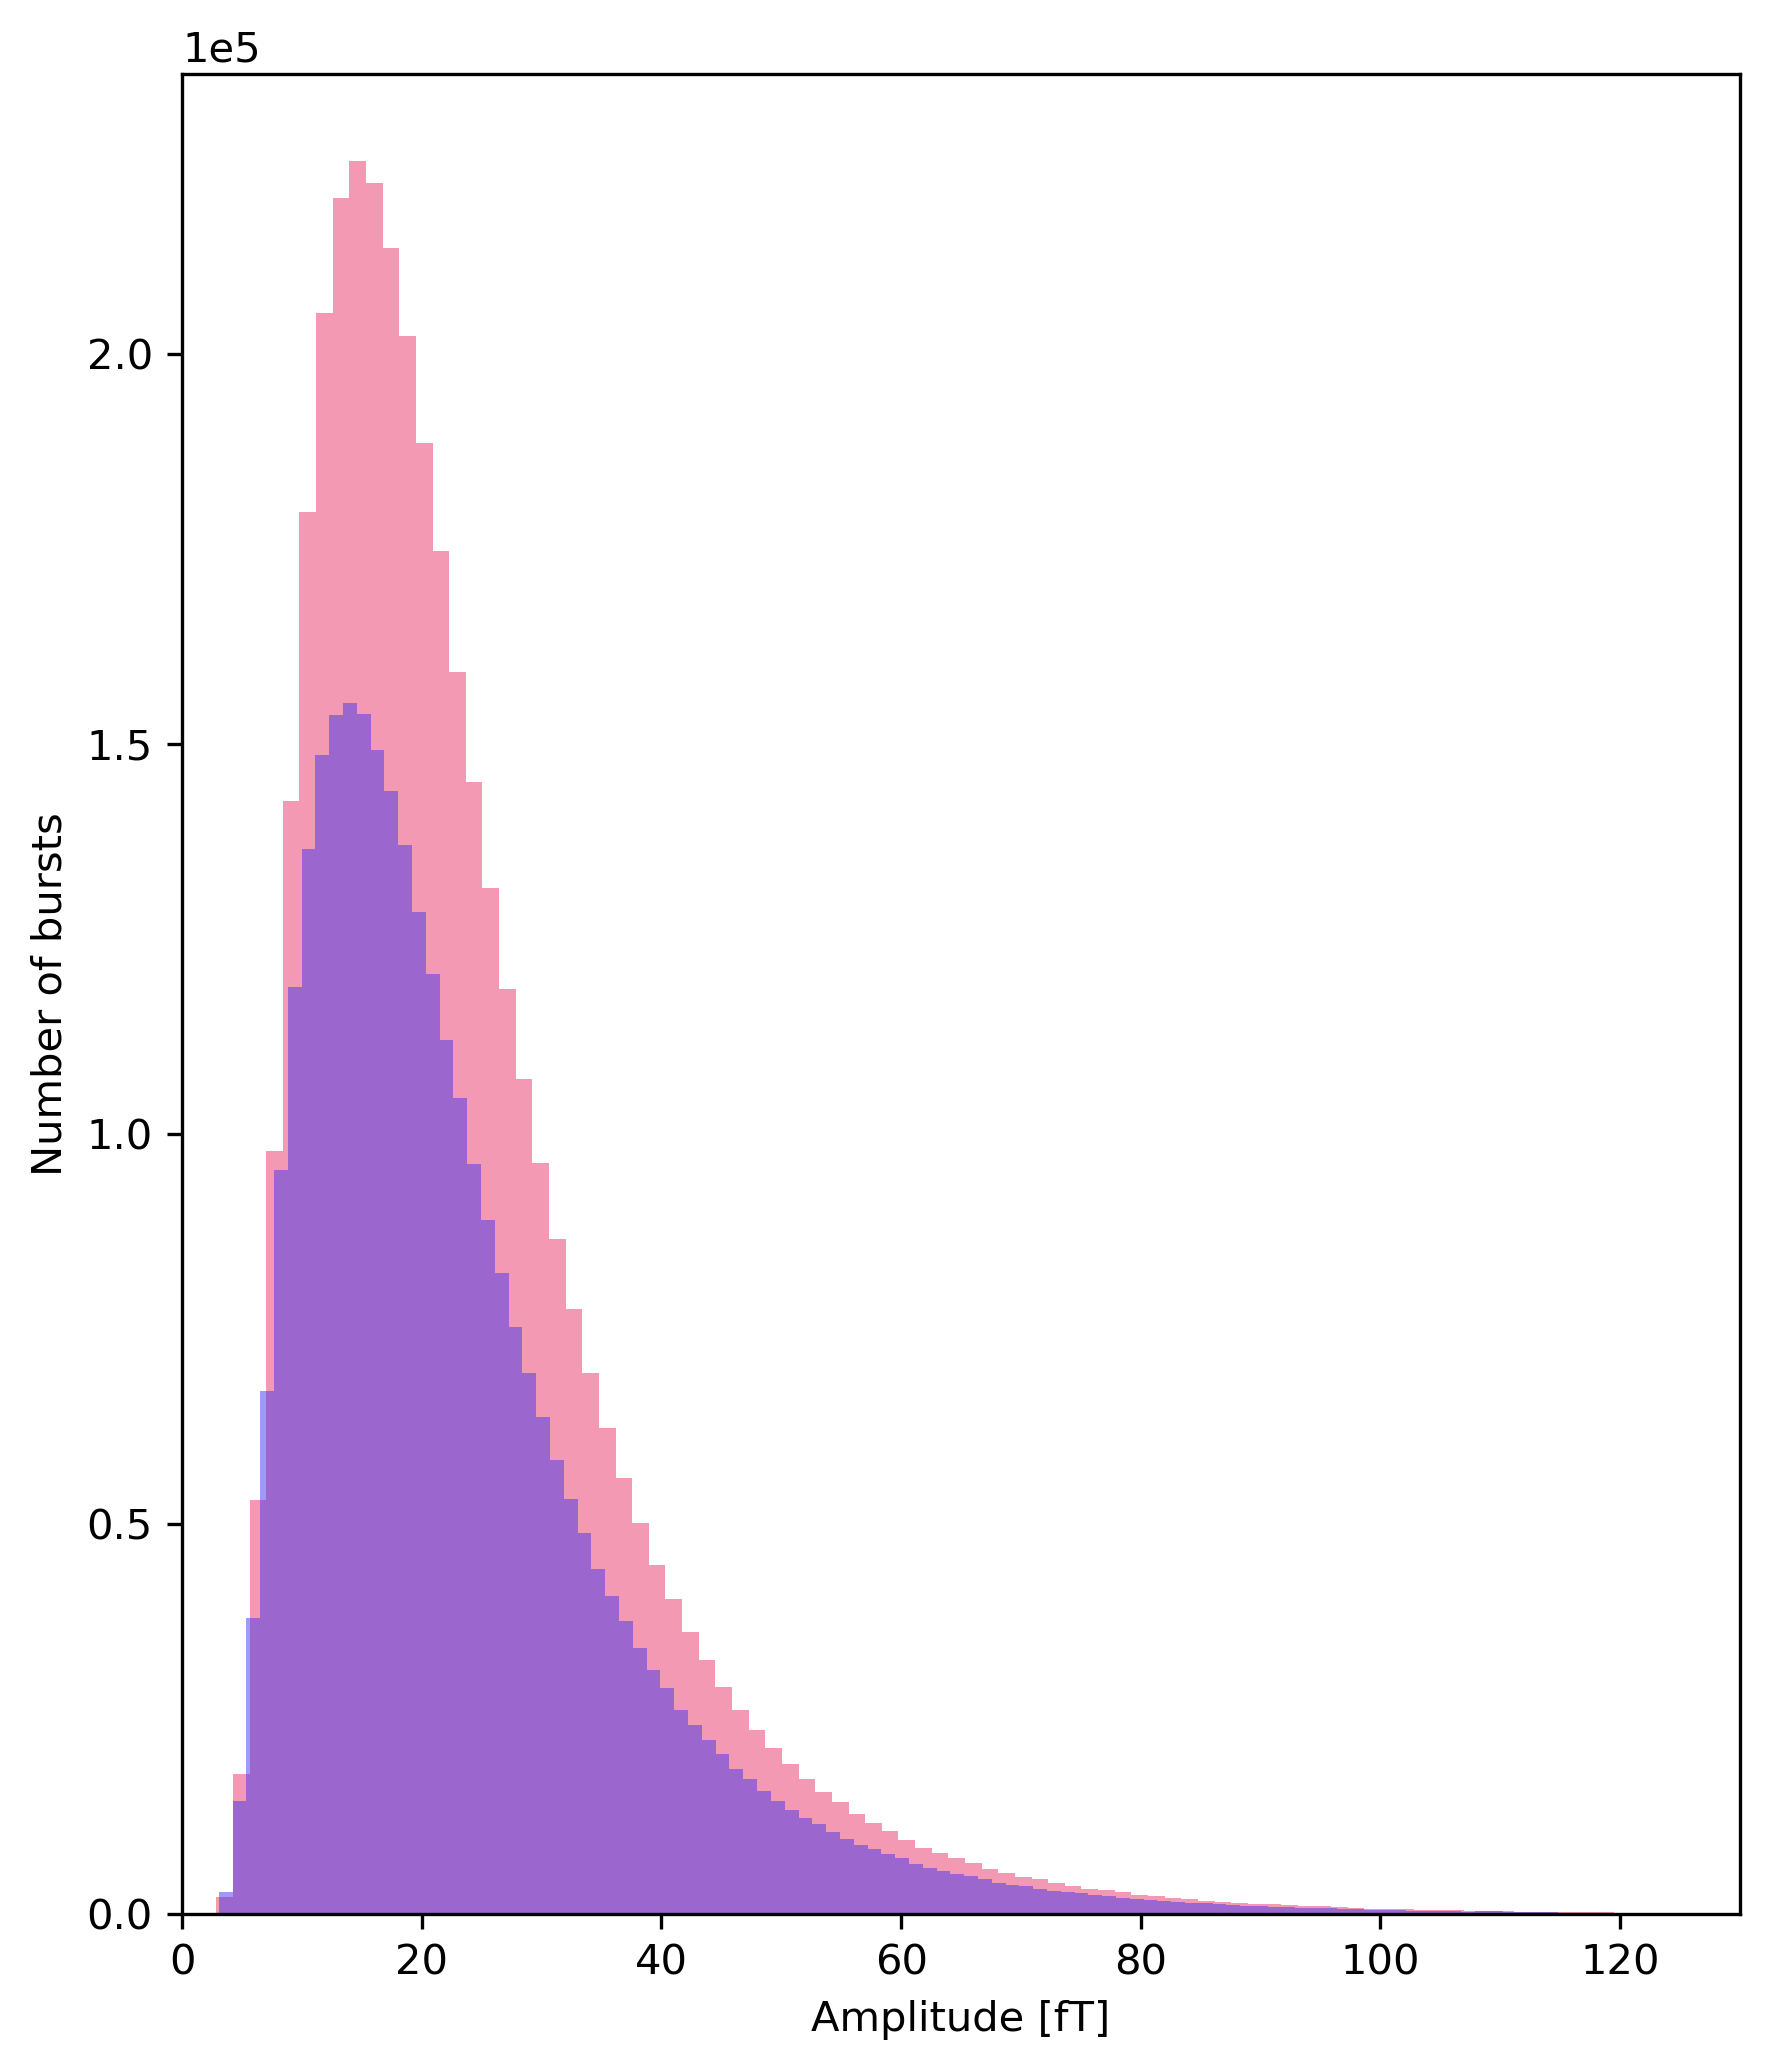

In [65]:
cw_m = "#4634eb"
cw_v = "#eb346b"

f, ax = plt.subplots(1, 1, figsize=(6, 7), dpi=300)
ax.hist(columns_dict.loc[columns_dict.trial_type == "visual"].peak_amp_base.values/1e-15, bins=200, alpha=0.5, color=cw_v);
ax.hist(columns_dict.loc[columns_dict.trial_type == "motor"].peak_amp_base.values/1e-15, bins=200, alpha=0.5, color=cw_m);
ax.set_ylabel("Number of bursts")
ax.set_xlabel("Amplitude [fT]")
ax.set_xlim(0, 130)
ax.ticklabel_format(axis="y", style="sci", scilimits=(10, 3))
plt.tight_layout()
plt.savefig("/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/images/3SD_burst_amplitude_hist.svg")

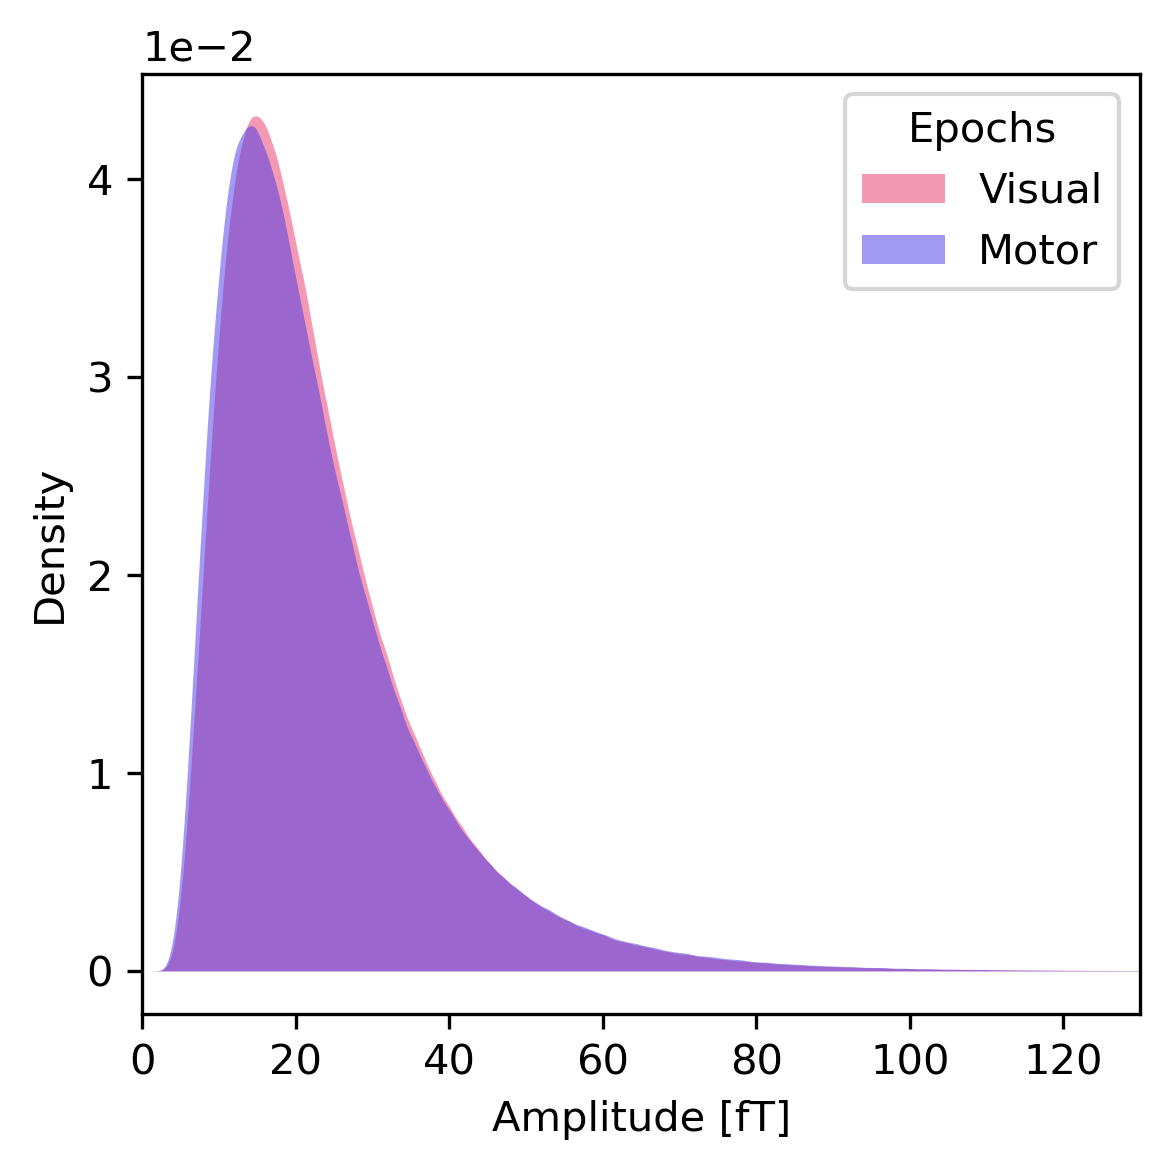

In [26]:
cw_m = "#4634eb"
cw_v = "#eb346b"

f, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=300)

kde_vis = sm.nonparametric.KDEUnivariate(columns_dict.loc[columns_dict.trial_type == "visual"].peak_amp_base.values/1e-15)
kde_vis.fit(bw=0.5)
kde_mot = sm.nonparametric.KDEUnivariate(columns_dict.loc[columns_dict.trial_type == "motor"].peak_amp_base.values/1e-15)
kde_mot.fit(bw=0.5)

ax.fill_between(kde_vis.support, 0, kde_vis.density, lw=0, color=cw_v, label="Visual", alpha=0.5, rasterized=True)
ax.fill_between(kde_mot.support, 0, kde_mot.density, lw=0, color=cw_m, label="Motor", alpha=0.5, rasterized=True)

ax.legend(title="Epochs")
ax.ticklabel_format(axis="y", style="sci", scilimits=(10, 3))
ax.set_ylabel("Density")
ax.set_xlabel("Amplitude [fT]")
ax.set_xlim(0, 130)
plt.tight_layout()
plt.savefig("/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/images/3SD_burst_amplitude_kde.svg")

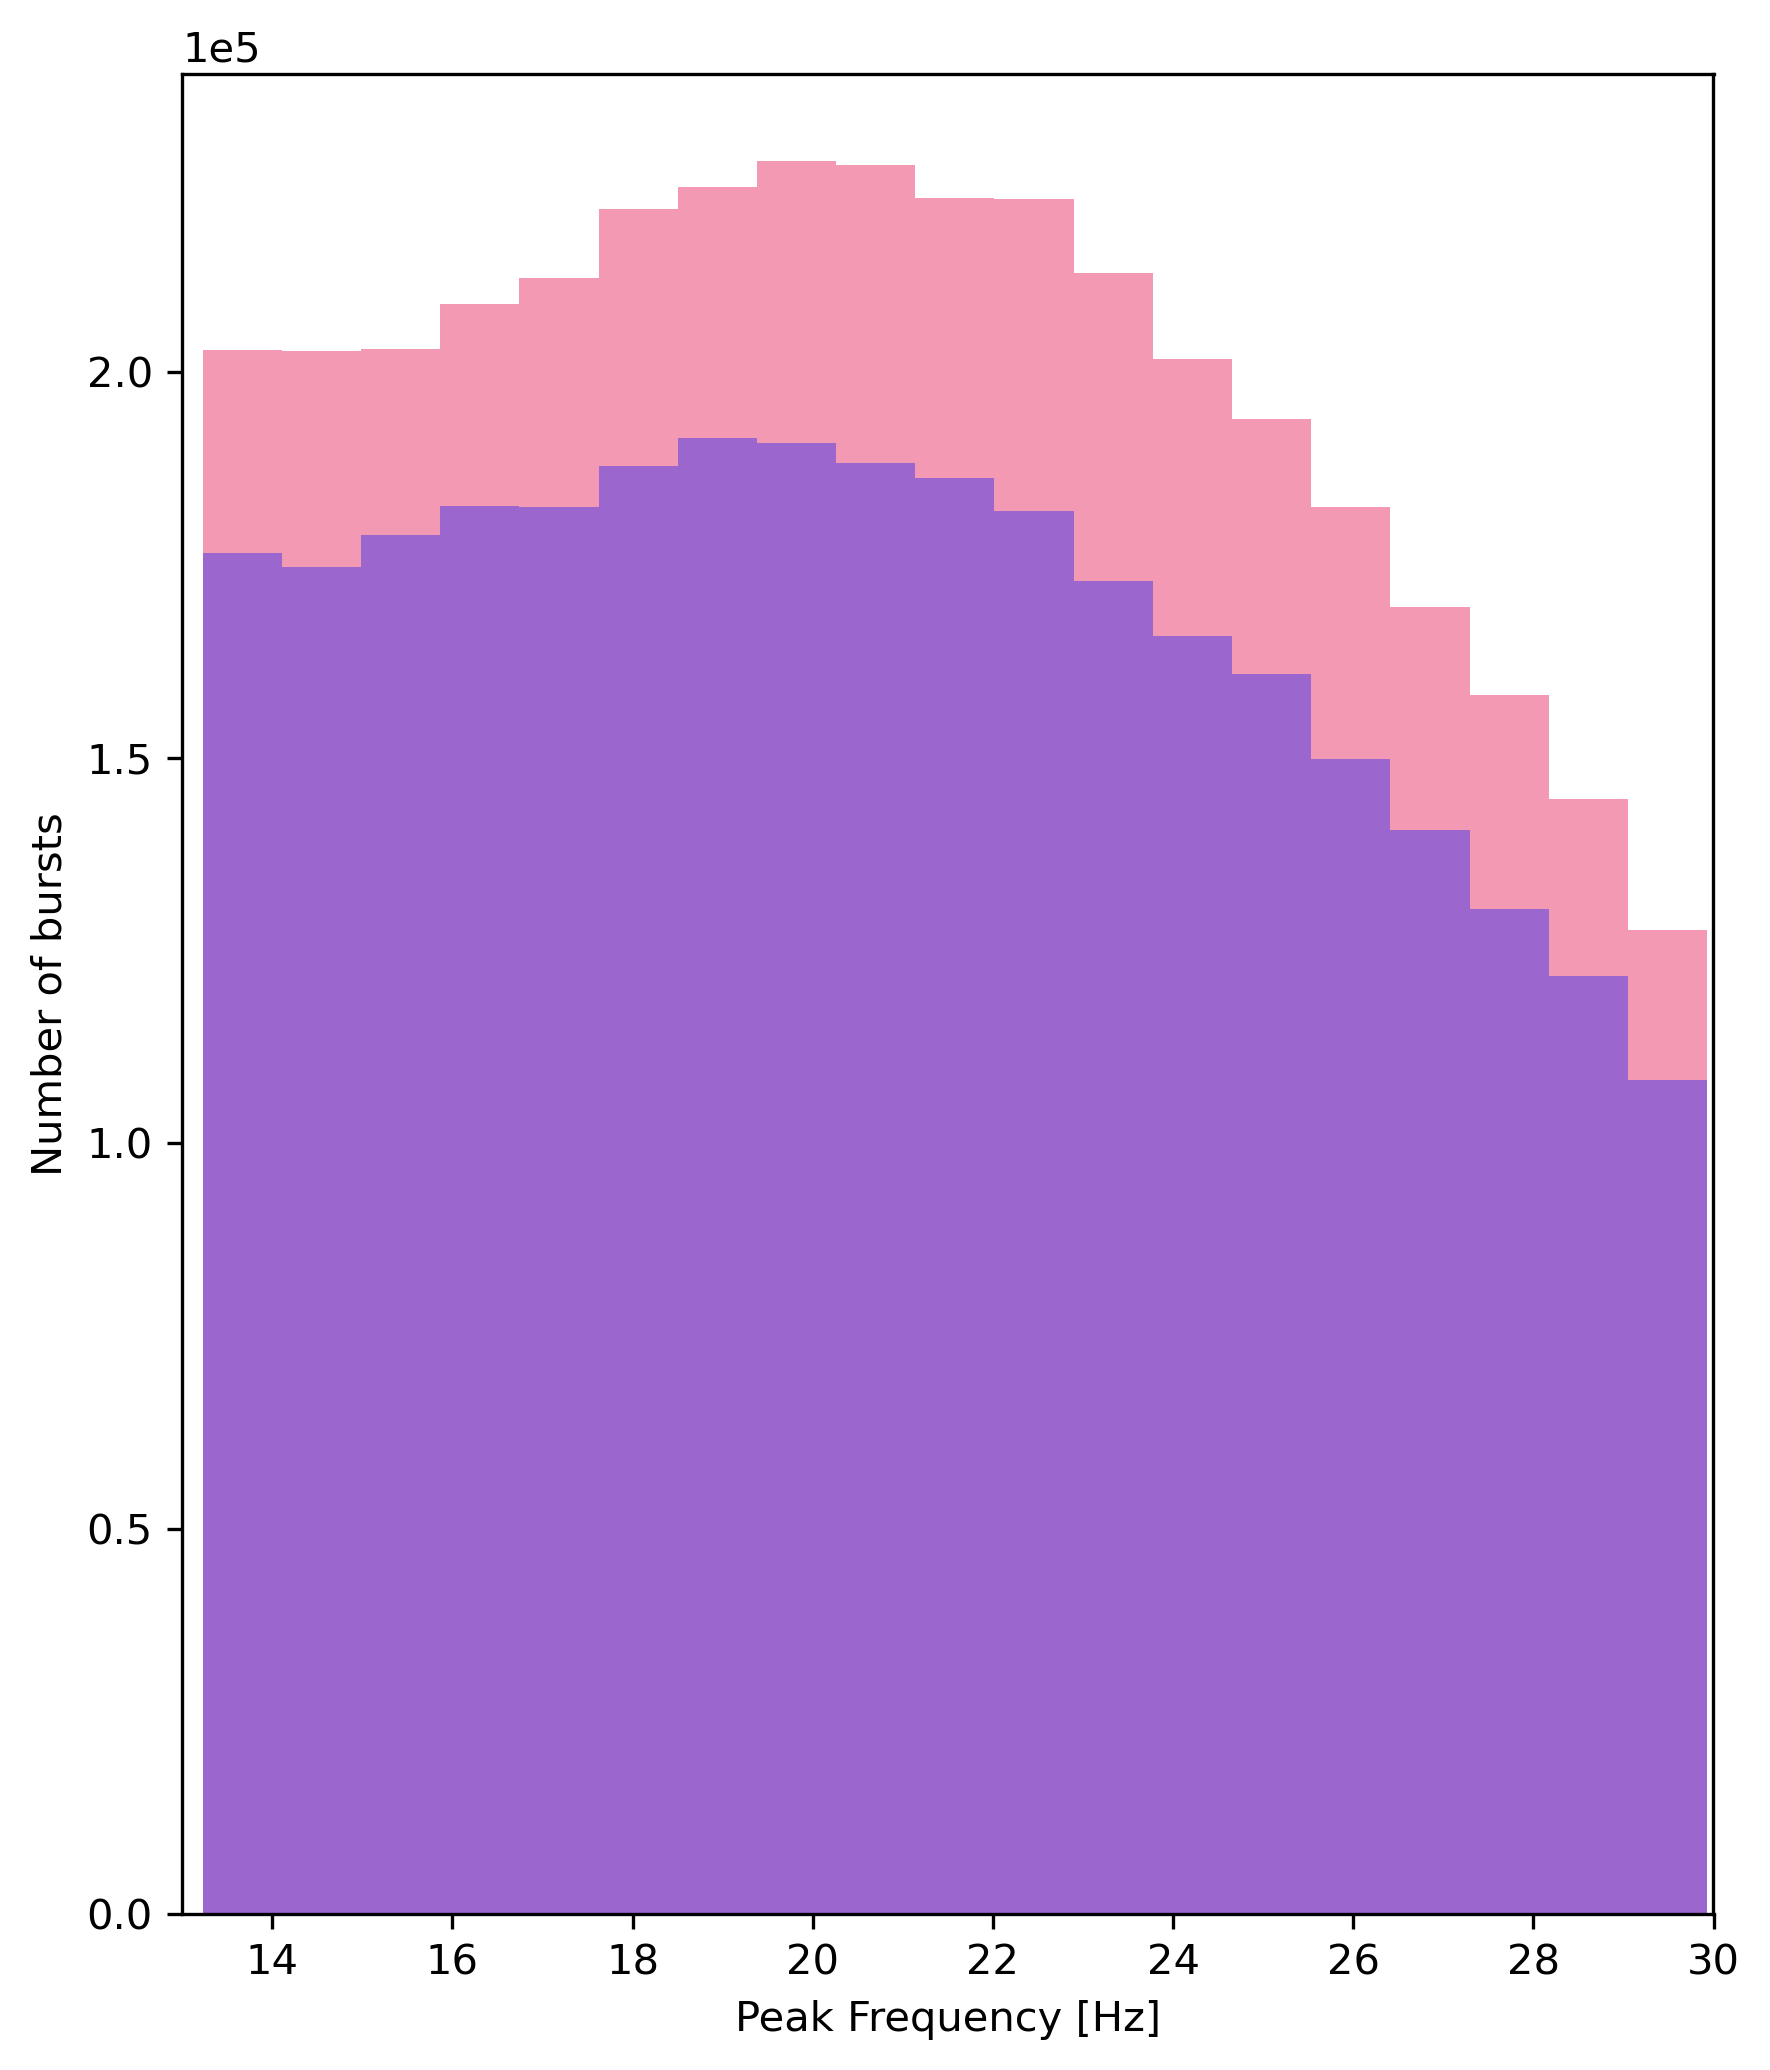

In [80]:
cw_m = "#4634eb"
cw_v = "#eb346b"

f, ax = plt.subplots(1, 1, figsize=(6, 7), dpi=300)
ax.hist(columns_dict.loc[columns_dict.trial_type == "visual"].peak_freq.values, bins=19, alpha=0.5, color=cw_v);
ax.hist(columns_dict.loc[columns_dict.trial_type == "motor"].peak_freq.values, bins=19, alpha=0.5, color=cw_m);
ax.set_xlim(13, 30)
ax.set_ylabel("Number of bursts")
ax.set_xlabel("Peak Frequency [Hz]")
ax.ticklabel_format(axis="y", style="sci", scilimits=(10, 3))
plt.tight_layout()
plt.savefig("/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/images/3SD_burst_peak_frequency_hist.svg")

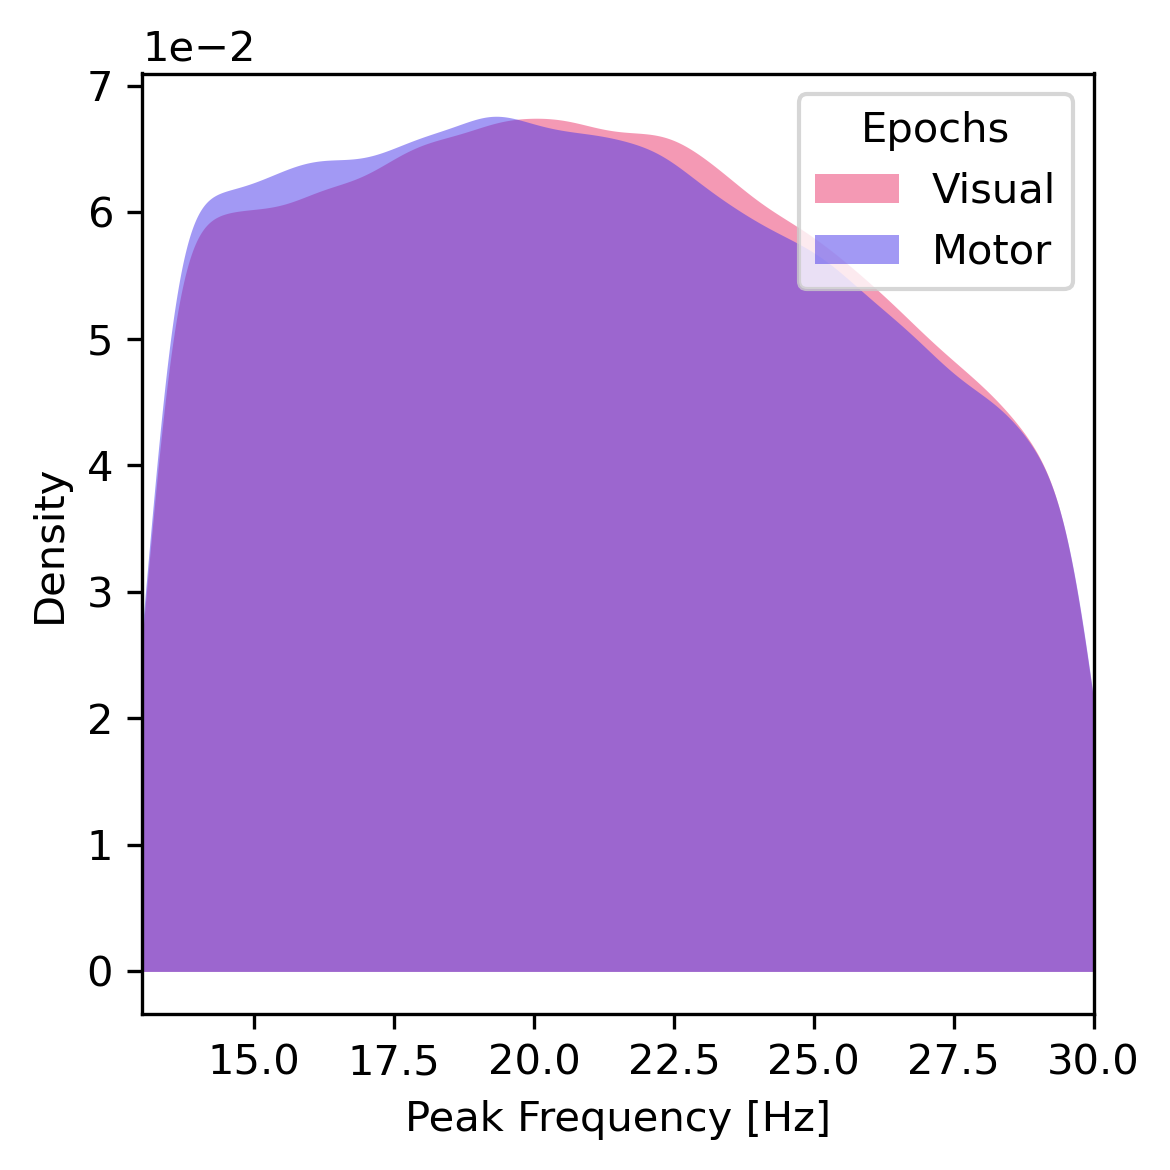

In [25]:
cw_m = "#4634eb"
cw_v = "#eb346b"

f, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=300)

kde_vis = sm.nonparametric.KDEUnivariate(columns_dict.loc[columns_dict.trial_type == "visual"].peak_freq.values)
kde_vis.fit(bw=0.5)
kde_mot = sm.nonparametric.KDEUnivariate(columns_dict.loc[columns_dict.trial_type == "motor"].peak_freq.values)
kde_mot.fit(bw=0.5)

ax.fill_between(kde_vis.support, 0, kde_vis.density, lw=0, color=cw_v, label="Visual", alpha=0.5, rasterized=True)
ax.fill_between(kde_mot.support, 0, kde_mot.density, lw=0, color=cw_m, label="Motor", alpha=0.5, rasterized=True)

ax.legend(title="Epochs")
ax.ticklabel_format(axis="y", style="sci", scilimits=(10, 3))
ax.set_xlim(13, 30)
ax.set_ylabel("Density")
ax.set_xlabel("Peak Frequency [Hz]")
plt.tight_layout()
plt.savefig("/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/images/3SD_burst_peak_frequency_kde.svg")

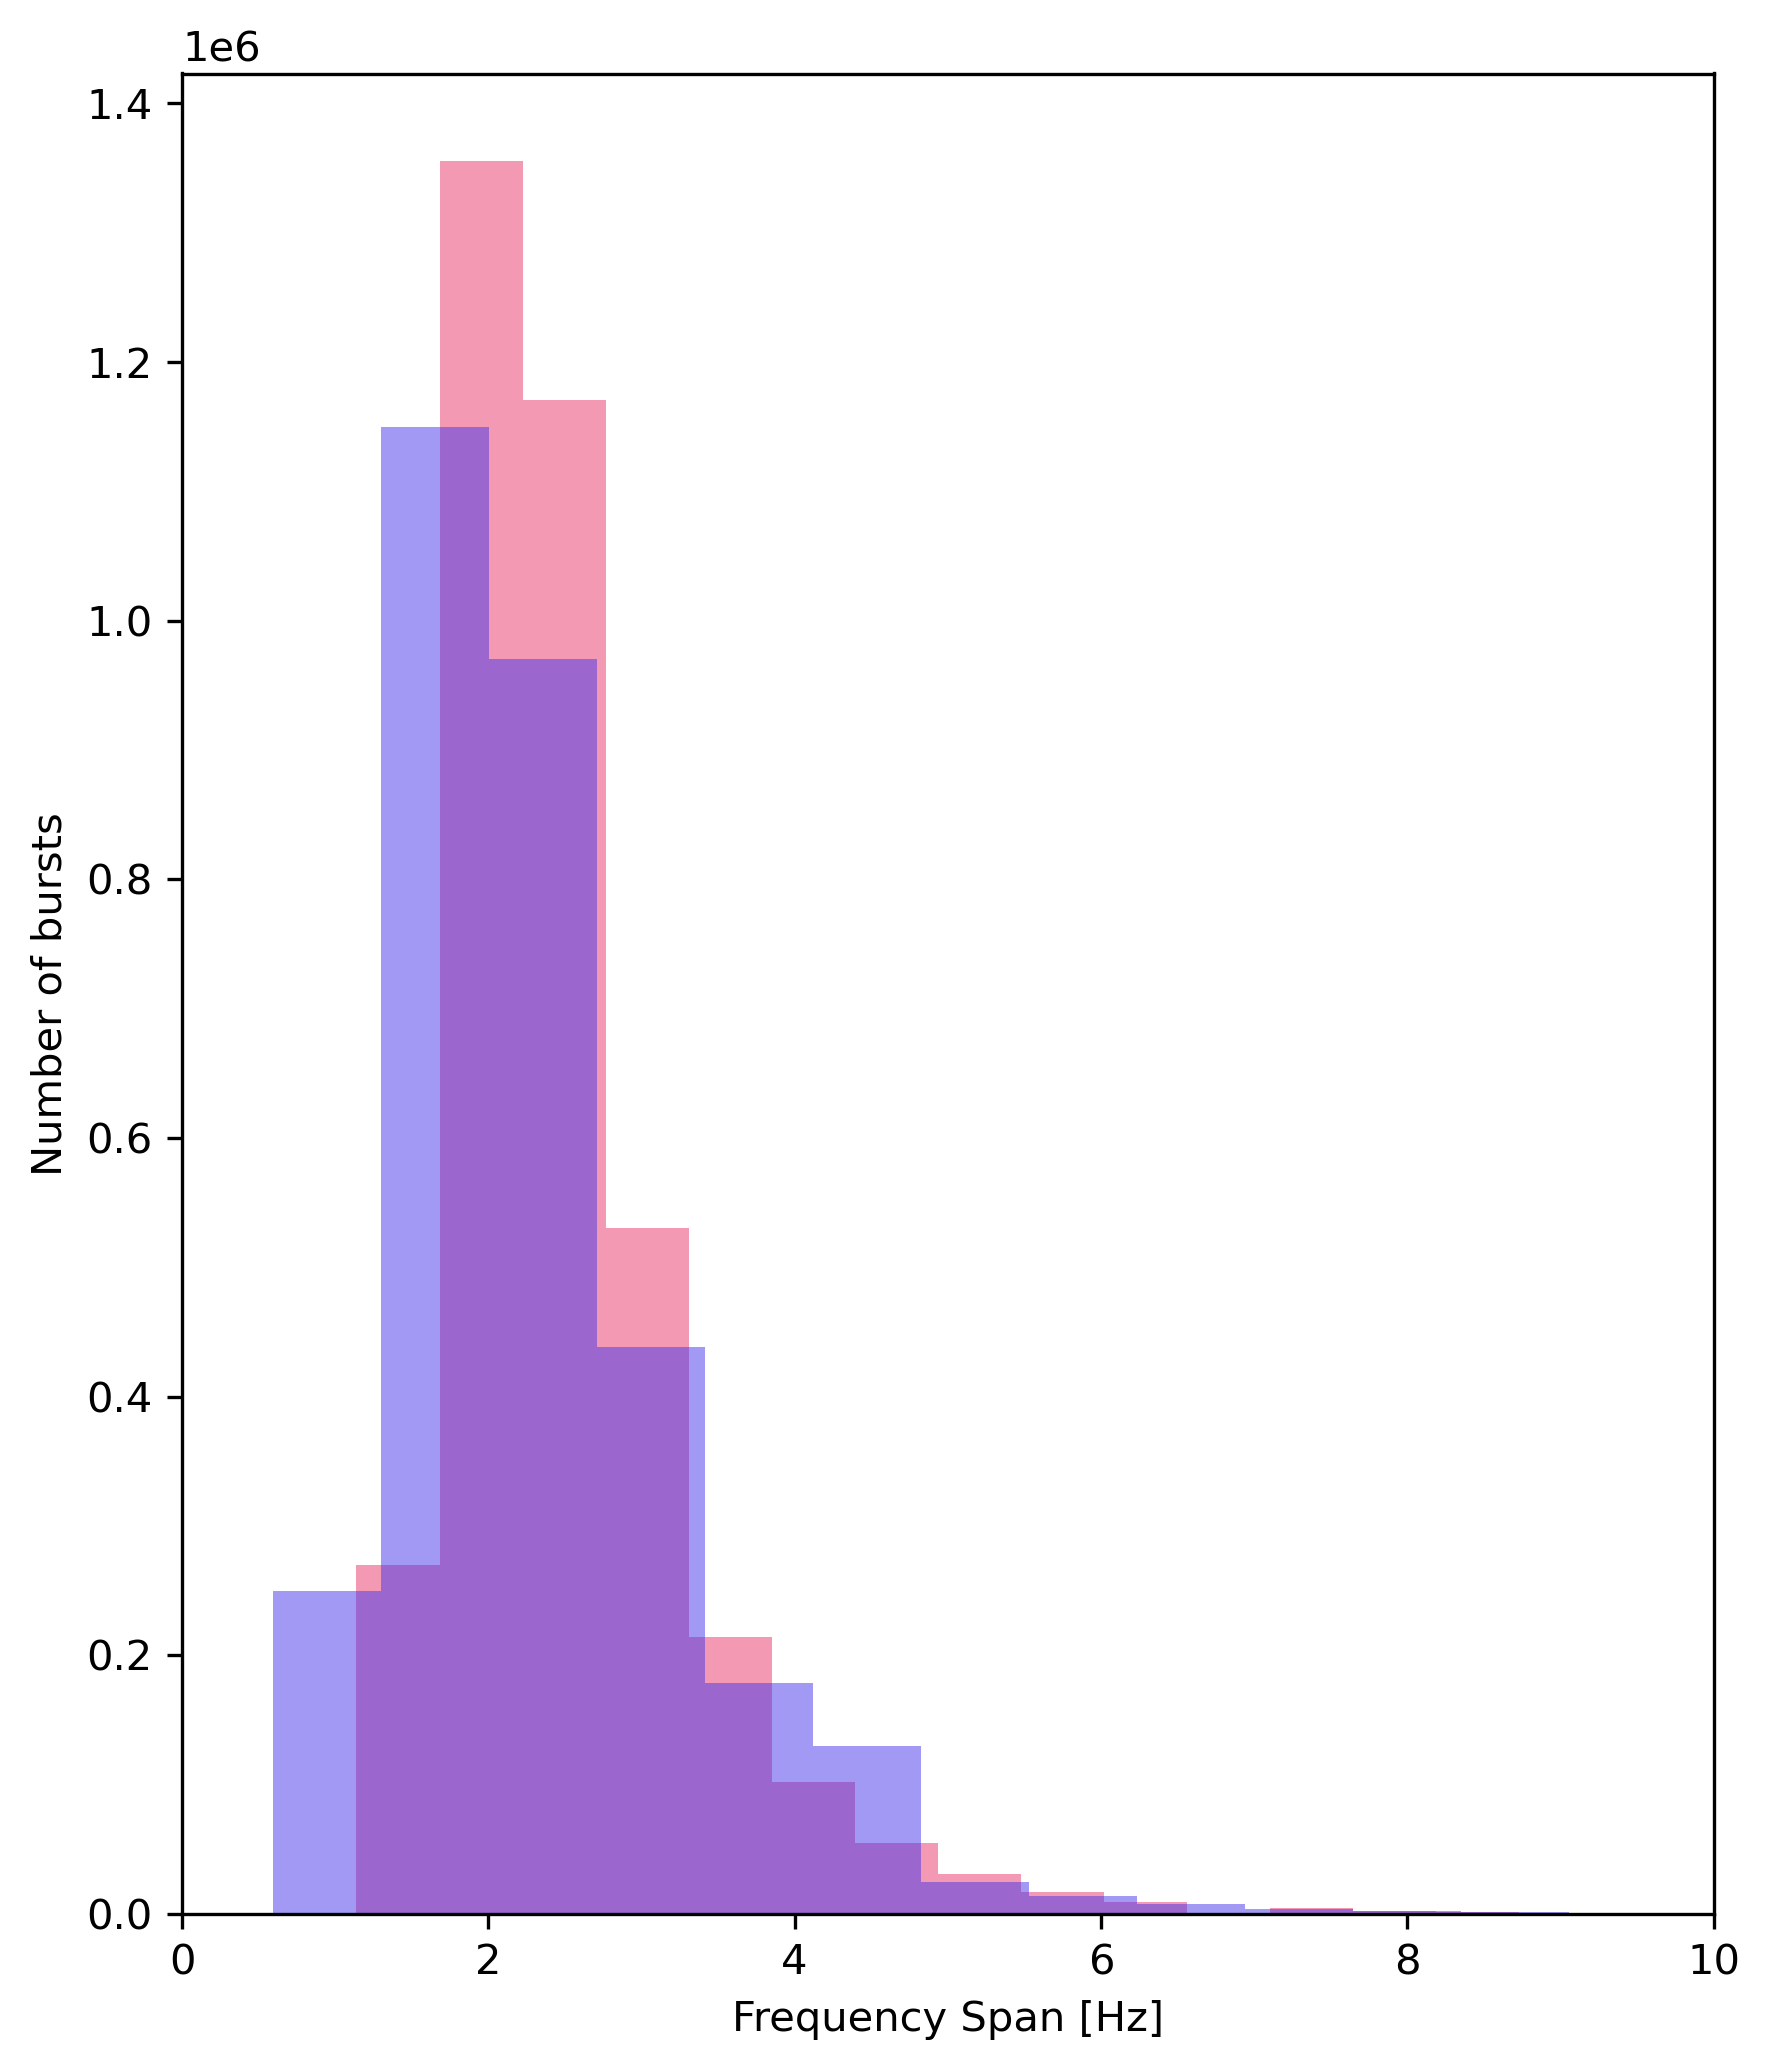

In [87]:
cw_m = "#4634eb"
cw_v = "#eb346b"

f, ax = plt.subplots(1, 1, figsize=(6, 7), dpi=300)
ax.hist(columns_dict.loc[columns_dict.trial_type == "visual"].fwhm_freq.values, bins=33, alpha=0.5, color=cw_v);
ax.hist(columns_dict.loc[columns_dict.trial_type == "motor"].fwhm_freq.values, bins=33, alpha=0.5, color=cw_m);
ax.set_xlim(0, 10)
ax.set_ylabel("Number of bursts")
ax.set_xlabel("Frequency Span [Hz]")
ax.ticklabel_format(axis="y", style="sci", scilimits=(10, 3))
plt.tight_layout()
plt.savefig("/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/images/3SD_burst_freq_span_hist.svg")

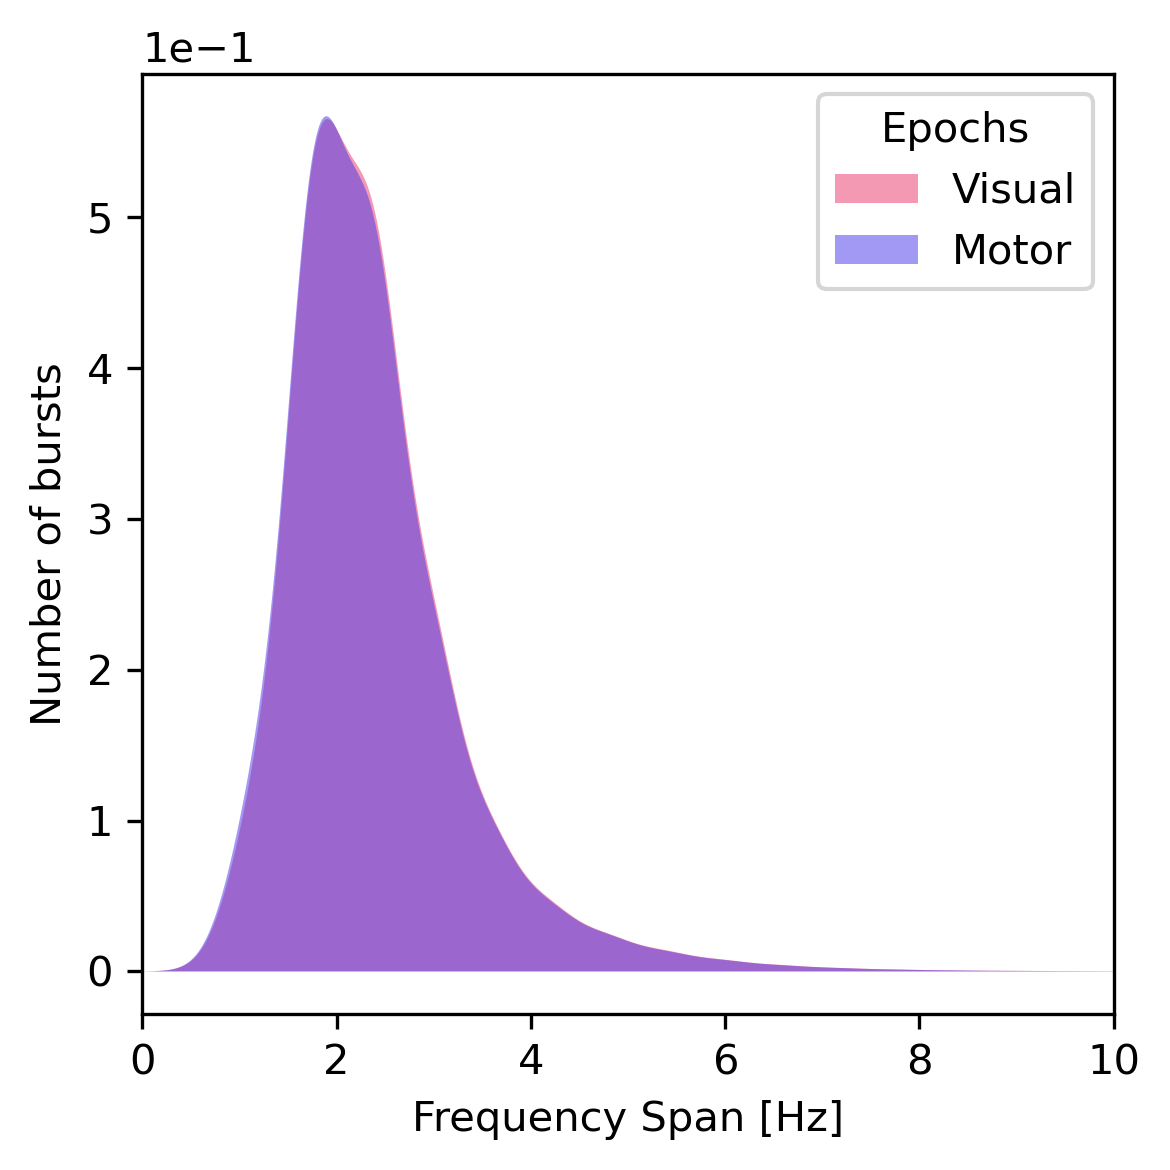

In [24]:
cw_m = "#4634eb"
cw_v = "#eb346b"

f, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=300)

kde_vis = sm.nonparametric.KDEUnivariate(columns_dict.loc[columns_dict.trial_type == "visual"].fwhm_freq.values)
kde_vis.fit(bw=0.3)
kde_mot = sm.nonparametric.KDEUnivariate(columns_dict.loc[columns_dict.trial_type == "motor"].fwhm_freq.values)
kde_mot.fit(bw=0.3)

ax.fill_between(kde_vis.support, 0, kde_vis.density, lw=0, color=cw_v, label="Visual", alpha=0.5, rasterized=True)
ax.fill_between(kde_mot.support, 0, kde_mot.density, lw=0, color=cw_m, label="Motor", alpha=0.5, rasterized=True)

ax.legend(title="Epochs")
ax.ticklabel_format(axis="y", style="sci", scilimits=(10, 3))
ax.set_xlim(0, 10)
ax.set_ylabel("Number of bursts")
ax.set_xlabel("Frequency Span [Hz]")
plt.tight_layout()
plt.savefig("/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/images/3SD_burst_freq_span_kde.svg")

In [89]:
scaler_path = "/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/scaler_MEG.pkl"
PCA_path = "/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/pca_solution_MEG.pkl"
with open(PCA_path, "rb") as input_file:
    big_pca = pickle.load(input_file)
with open(scaler_path, "rb") as input_file:
    big_scaler = pickle.load(input_file)

In [91]:
PCA_3SD = PCA(n_components=20)
PCA_3SD.fit(big_scaler.transform(waveforms))

PCA(n_components=20)

In [95]:
components_range = list(it.product(range(20), repeat=2))

f_r = np.zeros((20,20))
f_p = np.zeros((20,20))

for r, c in components_range:
    f_r[r,c], f_p[r,c] = spearmanr(
        PCA_3SD.components_[r],
        big_pca.components_[c]
    )

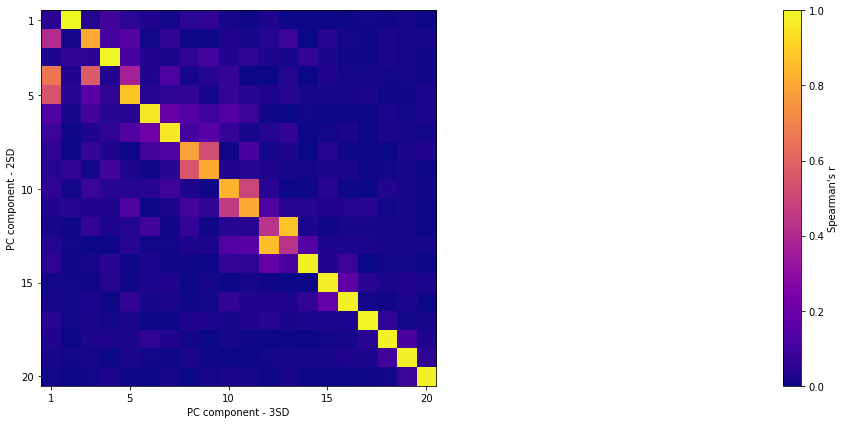

In [102]:
f, ax = plt.subplots(1,2, figsize=[12,6], facecolor="white")
x = ax[0].imshow(
    np.abs(f_r), origin="upper",
    aspect="auto",
    extent=[0,20,20,0],
    vmin=0, vmax=1,
    cmap="plasma"
)
ax[1].axis("off")

tick_labels = np.array([1, 5, 10, 15, 20])
ticks = tick_labels - 0.5
ax[0].set_xticks(ticks)
ax[0].set_yticks(ticks)
ax[0].set_xticklabels(tick_labels)
ax[0].set_yticklabels(tick_labels)
ax[0].set_xlabel("")
ax[0].set_ylabel("PC component - 2SD")
ax[0].set_xlabel("PC component - 3SD")

plt.colorbar(x, label="Spearman's r")
plt.tight_layout()
plt.savefig("/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/images/pca_eigenvector_2SDvs3SD.svg")

In [103]:
PCA_3SD.explained_variance_ratio_

array([0.12133543, 0.10664978, 0.09300121, 0.09175442, 0.0757041 ,
       0.06583488, 0.04979782, 0.04198218, 0.03568733, 0.02848103,
       0.02514911, 0.02139844, 0.0195382 , 0.01446775, 0.01306248,
       0.01263091, 0.01016989, 0.00904521, 0.00780263, 0.00691012])